In [28]:
import sys
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import h5py
from datetime import datetime
import time
import pickle

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from torch.nn.functional import one_hot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import sequenceCnnModel
import sequenceDataset
import config
import utils

import importlib

importlib.reload(sequenceCnnModel)
importlib.reload(sequenceDataset)
importlib.reload(config)
importlib.reload(utils)

import seaborn as sns

arguments in file sequenceDataset are {'coordStoreDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latestTestCoordinateFiles', 'refGenomePath': '/hpc/compgen/projects/fragclass/raw/hg19_genome/hg19_ch1-22_XYM.fa', 'modelInputSequenceSize': 330, 'runWithControls': False, 'usePaddingForCnn': True, 'interchangeLabels': False, 'trainingCoordsDatasetName': 'trainingCoords', 'validationCoordsDatasetName': 'validationCoords', 'testCoordsDatasetName': 'testCoords', 'trainingLabelsDatasetName': 'trainingLabels', 'validationLabelsDatasetName': 'validationLabels', 'testLabelsDatasetName': 'testLabels'}


In [31]:
arguments = {}
#File paths
arguments["trainingAndValidationOutputsDirectory"] = config.filePaths.get("trainingAndValidationOutputsDirectoryCnn")
arguments["coordStoreDirectory"] = config.filePaths.get("coordStoreDirectory")
arguments["patientTransplantStatusFile"] = config.filePaths.get("patientTransplantStatusFile")
arguments["modelStateDictPath"] = config.filePaths.get("modelStateDictPath")
arguments["testModelPlotsDir"] = config.filePaths.get("testModelPlotsDir")

#Model hyperparameters 
arguments["threshold"] = config.modelHyperParameters.get("classificationThreshold")
arguments["batchSize"] = config.modelHyperParameters.get("batchSize")
arguments["learningRate"] = config.modelHyperParameters.get("learningRate")
arguments["numEpochs"] = config.modelHyperParameters.get("numberEpochs")
arguments["numWorkers"] = config.modelHyperParameters.get("numberOfWorkers")

#Model general configs
arguments["modelName"] = config.modelGeneralConfigs.get("modelName")
arguments["storePlots"] = config.modelGeneralConfigs.get("storePlots")
arguments["addLengthAsFeature"] = config.modelGeneralConfigs.get("addLengthAsFeature")
arguments["ddCfDnaPercentageThreshold"] = config.modelGeneralConfigs.get("ddCfDnaPercentageThreshold")

#Datasets
arguments["trainingLabelsDatasetName"] = config.datasetNames.get("trainingLabels")
arguments["validationLabelsDatasetName"] = config.datasetNames.get("validationLabels")
arguments["testLabelsDatasetName"] = config.datasetNames.get("testLabels")

print(f"Arguments in validate_model script are {arguments}")
print(f"\n\n \033[1mDid you check whether interchangeLabels, sequenceDataset is set to the right configurations ??\033[0m")

Arguments in validate_model script are {'trainingAndValidationOutputsDirectory': None, 'coordStoreDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latestTestCoordinateFiles', 'patientTransplantStatusFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/L29_transplant_status.csv', 'modelStateDictPath': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/20_aug_cnn_trials/30_08_17_28_33_model_2_padding_length_feature/modelState', 'testModelPlotsDir': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/testModelPlotsDir', 'threshold': 0.5, 'batchSize': 128, 'learningRate': 0.0001, 'numEpochs': 5, 'numWorkers': 12, 'modelName': 'lr_0.0001_filters_40_80', 'storePlots': True, 'addLengthAsFeature': False, 'ddCfDnaPercentageThreshold': 1, 'trainingLabelsDatasetName': 'trainingLabels', 'validationLabelsDatasetName': 'validationLabels', 'testLabelsDatasetName': 'testLabels'}


 Did you check whether

**Returns the samples in batches for a particular patient** (The sequenceDataset class is for getting the samples for all the files in a given directory together. For an index, it gets the filename and gets the samples. We want the filenames to be in the exact order everytime - because thats how we match the predictions to the patient. So the sequenceDataset won't work)

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, filename):
        self.filename = filename

    def __getitem__(self, index):     
        filepath = os.path.join(arguments["coordStoreDirectory"], self.filename)
        
        with h5py.File(filepath, 'r') as f:
            coord = f[self.coordDatasetName][index]

            #Each sample should have only one label, it should be a single value instead of a numpy 1D array.The [0] is to make it a single value instead of a numpy array.
            # label = f['trainingLabels'][index][0]
            label = f[self.labelsDatasetName][:][index]

            # if(arguments["interchangeLabels"] == True):
            #     labels = self.interchangeLabels(labels)

            sequenceOutputLength = arguments["modelInputSequenceSize"]
            expected_sequence_length = 196607 if sequenceOutputLength == "enformer" else sequenceOutputLength
            encoded_input_sequence, bins, og_sequence_length = utils.getOneHotEncodedSequenceFromCoordinates(coord, arguments["refGenomePath"],
                                                                                         sequenceOutputLength, arguments["usePaddingForCnn"])
            #For some cases, the coordinates look fine, but the sequence fetched from the fasta file has size 0. 
            #If we pass such samples to enformer for predictions, we get Einops error, due to dimension mismatch.
            assert encoded_input_sequence.shape == (expected_sequence_length, 4), f"One of the samples did not have the right dimensions({(expected_sequence_length, 4)}). The sample index is {index}, shape is {encoded_input_sequence.shape}, filename is {filename} and index within the file is {indexWithinFile}"
            
            if(arguments["runWithControls"]):
                encoded_input_sequence = self.addPositiveAndNegativeControls(encoded_input_sequence, label[0])
        
        return encoded_input_sequence, label, bins, filepath, indexWithinFile, og_sequence_length 

    def __len__(self):
        #Total number of samples is the startIndexList of the last file + number of samples in the last file. 
        lastStartIndex = self.startIndexList[-1]
        lastFileName = self.fileNamesList[-1]
        numSamplesLastFile = utils.getNumberLinesInFile(arguments["coordStoreDirectory"], lastFileName, self.coordDatasetName)
        totalNumSamples = lastStartIndex + numSamplesLastFile
        return totalNumSamples

**All the functions for plotting**

In [38]:
def getParametersDescription():
    if(arguments["modelInputType"] == "Sequence"):
        numPositives = 0
        numNegatives = 0
        labelsDatasetName = arguments["testLabelsDatasetName"]
        for filename in os.listdir(arguments["coordStoreDirectory"]):
            filePath = os.path.join(arguments["coordStoreDirectory"], filename)
            with h5py.File(filePath, 'r') as f:
                samples = f[labelsDatasetName][:]
                numPositives += (samples == 1).sum()
                numNegatives += (samples == 0).sum()

    elif(arguments["modelInputType"] == "Enformer"):
        with h5py.File(arguments["testEnformerStoreFile"], 'r') as f:
            samples = f[labelsDatasetName][:]
            numPositives = (samples == 1).sum()
            numNegatives = (samples == 0).sum()

    totalSamples = numPositives + numNegatives
    description = (f"Number of samples = {totalSamples} ({numPositives} positives and {numNegatives} negatives)")
    return description

def get_softmax(preds_array):
    preds_exp = np.exp(preds_array)
    sum_array = np.sum(preds_exp, axis = 1)
    softmax_preds = preds_exp/sum_array[:, None]
    return softmax_preds

def getClassPredictionsAndProbsFromOutput(plotsData):
    threshold = arguments["threshold"]
    predicted_labels = []
    predictions = plotsData["predictions"]

    #Apply softmax function to convert the prediction into probabilities between 0 and 1. This is used for plotting
    #the frequency of the outcomes to know how sure the model was for different data points. 
    #Model prediction is a 2D array of size (batchSize * 2). The 2 values are the probabilities for the positive and negative for each sample in the batch.
    # Whichever of the 2 labels has the highest probabilities is taken as the final predicted label of the model. 
    #If the probabilities added upto 1, this would count as taking 0.5 as the threshold for considering a class as the prediction. 
    #Iterate through all the positive probabilities predictions in the batch and extend the predictions list with all the predictions for the batch. 
    softmax_preds = np.around(get_softmax(predictions), 4)
    #TODO figure out which probability is for the positives. 
    softmax_positives = softmax_preds.transpose()[1].flatten()
    for prob in softmax_positives: 
        if prob > threshold: 
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)

    return softmax_positives, predicted_labels

def getConfusionMatrixLabels(cf_matrix):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    cf_matrix_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    cf_matrix_labels = np.asarray(cf_matrix_labels).reshape(2,2)
    return cf_matrix_labels

def getPatientLevelTransplantPredictions(predicted_labels):
    col_names = ["patient_sample_id", "num_samples", "percentage_donors", "transplant_status"]
    patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)
    patient_transplant_status_predictions = []
    percentage_donors_predictions = []
    start_sample_index = 0
    end_sample_index = 0

    for i, row in patient_labels_df.iterrows():
        num_samples = row["num_samples"] 
        end_sample_index = end_sample_index + num_samples
        predicted_num_donors = predicted_labels[start_sample_index: end_sample_index].count(1)
        percentage_donors = (predicted_num_donors/num_samples) * 100
        percentage_donors_predictions.append(percentage_donors)

        #If % donor fragments for a patient exceeds threshold, set the transplant status as 1. 
        if(percentage_donors > arguments["ddCfDnaPercentageThreshold"]):
            patient_transplant_status_predictions.append(1)
        else:
            patient_transplant_status_predictions.append(0)

        start_sample_index = end_sample_index

    print(f"In get patient level transplant status, the final end index is {end_sample_index} and length of predicted labels is {len(predicted_labels)}")
    return percentage_donors_predictions, patient_transplant_status_predictions
    

def getPatientLevelCfMatrixAndLabels(predicted_labels):
    col_names = ["patient_sample_id", "num_samples", "percentage_donors", "transplant_status"]
    patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)
    patient_level_percentage_donor_predictions, patient_transplant_status_predcictions = getPatientLevelTransplantPredictions(predicted_labels)
    print(f"Patient level percentage donor predictions are {patient_level_percentage_donor_predictions}")
    cf_matrix = confusion_matrix(patient_labels_df["transplant_status"], patient_transplant_status_predcictions)
    cf_matrix_labels = getConfusionMatrixLabels(cf_matrix)
    return cf_matrix, cf_matrix_labels, patient_level_percentage_donor_predictions

def getfragmentLevelCfMatrixAndLabels(data, predicted_labels):
    true_labels = data["labels"]
    cf_matrix = confusion_matrix(true_labels, predicted_labels)
    cf_matrix_labels = getConfusionMatrixLabels(cf_matrix)
    return cf_matrix, cf_matrix_labels

def storeConfusionMatrixHeatMap(plotsData, predicted_labels, plotsDirectoryPath):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 8))
    heatmap_description = getParametersDescription()
    fig.text(.5, -0.1, heatmap_description, ha = 'center', fontsize=12)
    
    fragment_cf_matrix, fragment_cf_matrix_labels = getfragmentLevelCfMatrixAndLabels(plotsData, predicted_labels)
    patient_cf_matrix, patient_cf_matrix_labels, patient_level_percentage_donor_predictions = getPatientLevelCfMatrixAndLabels(predicted_labels)

    s1 = sns.heatmap(fragment_cf_matrix, annot=fragment_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax1, annot_kws={"fontsize":12})
    s2 = sns.heatmap(patient_cf_matrix, annot=patient_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax2, annot_kws={"fontsize":12})
    s1.set_xlabel("Predicted Label", fontsize=12)
    s1.set_ylabel("True Label", fontsize=12)
    s2.set_xlabel("Predicted Label", fontsize=12)
    s2.set_ylabel("True Label", fontsize=12)
    fig.subplots_adjust(hspace=0.75, wspace=0.75)

    ax1.title.set_text(f'Fragment level')
    ax2.title.set_text(f'Patient level')

    if(arguments["storePlots"]):
        plotPath = os.path.join(plotsDirectoryPath, "confusionMatrix")
        plt.savefig(plotPath, bbox_inches='tight')

        #Store the patient level confusion matrix
        percentage_donors_pickle_path = os.path.join(plotsDirectoryPath, "percentageDonorPredictions.pkl")
        with open(percentage_donors_pickle_path, "ab") as tf:
            pickle.dump(patient_level_percentage_donor_predictions, tf)
    
    plt.show()
    plt.clf()


def storePredictedDonorsCorrelationPlot(predicted_labels, plotsDirectoryPath):
    col_names = ["patient_sample_id", "num_samples", "percentage_donors", "transplant_status"]
    patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)
    donor_percentage_predictions, _ = getPatientLevelTransplantPredictions(predicted_labels)
    plt.scatter(patient_labels_df["percentage_donors"], donor_percentage_predictions)
    plt.title(f'Correlation between predicted vs actual % donors')
    plt.xlabel('True % donors')
    plt.ylabel('Predicted %')
    if(arguments["storePlots"]):
        plotPath = os.path.join(plotsDirectoryPath, "percentageDonorsCorrelationPlot")
        plt.savefig(plotPath, bbox_inches='tight')
    plt.show()
    plt.clf()

def storeAucAndRocCurve(probabilities, plotsData, plotsDirectoryPath):
    #Get AUC and TPR, FPR for training
    labels = plotsData["labels"]
    auc_score = roc_auc_score(labels, probabilities)
    fpr, tpr, _ = roc_curve(labels, probabilities, pos_label=1)

    #Get AUC, TPR, FPR for a random predictor
    random_pred_val = [0 for i in range(len(labels))]
    r_fpr, r_tpr, _ = roc_curve(labels, random_pred_val, pos_label=1)

    plt.plot(fpr, tpr, linestyle='--',color='red', label='Test model ROC curve')
    plt.plot(r_fpr, r_tpr, linestyle='--', color='black')
    plt.title(f'ROC curve plot: AUC : {auc_score}')
    plt.xlabel('False Positive Rate/FPR')
    plt.ylabel('True Positive Rate/TPR')
    plt.legend(loc='best')
    if(arguments["storePlots"]):
        plotPath = os.path.join(plotsDirectoryPath, "ROC")
        plt.savefig(plotPath, bbox_inches='tight')

    plt.show()
    plt.clf()

def storeDataAndMakePlots(plotsData, modelInputType):
    now = datetime.now()
    filename_extension = now.strftime("%d_%m_%H_%M_%S")
    plotsDirectoryName = filename_extension + "_" + str(arguments["modelName"])
    plotsDirectoryPath = os.path.join(arguments["testModelPlotsDir"], plotsDirectoryName)
    if(arguments["storePlots"]):
        os.mkdir(plotsDirectoryPath)

    #Store the plotsData incase the model runs into any errors while plotting and all data is lost 
    plots_data_path = os.path.join(plotsDirectoryPath, "plotsData.pkl")
    with open(plots_data_path, "ab") as tf:
        pickle.dump(plotsData, tf)

    plt.style.use('seaborn')
    arguments["modelInputType"] = modelInputType

    #Get the softmax probabilities and the predicted class labels (using threshold) from model output 
    output_probabilities, class_predictions = getClassPredictionsAndProbsFromOutput(plotsData)
    print(f"Output probabilities : {len(output_probabilities)} and class preds: {len(class_predictions)}")
    storeAucAndRocCurve(output_probabilities, plotsData, plotsDirectoryPath)

    #Plot confusion matrix heat map for training and validation (only for last epoch)
    storeConfusionMatrixHeatMap(plotsData, class_predictions, plotsDirectoryPath)

    #Plot the correlation between predicted percentage donors and actual percentage donors for each sample 
    storePredictedDonorsCorrelationPlot(class_predictions, plotsDirectoryPath)


**Getting predictions from model**

In [40]:
def runModelAndGetPredictions():
    plotsData = {"labels": {}, "predictions": {}, "loss": {}}
    
    #Load state dict into the model 
    cnnModel = sequenceCnnModel.SequenceCnnModel(0).to('cuda')
    cnnModel.load_state_dict(torch.load(arguments["modelStateDictPath"]))
    cnnModel.eval()
    
    dataset = sequenceDataset.SequenceDataset("test")
    dataloader = DataLoader(dataset, batch_size=arguments["batchSize"], 
                                    num_workers=arguments["numWorkers"])

    criterion = nn.CrossEntropyLoss()

    num_batches = len(dataloader)
    store_plotting_data_interval = 3 if num_batches > 3000 else 1
    running_loss = 0.0

    modelPredictionsToRet = np.zeros(shape = (1, 2))
    modelInputLabelsToRet = []

    for i, data in enumerate(dataloader):
        sequence, class_labels, _, _, _, og_sequence_length = data
        if torch.cuda.is_available():
            sequence = sequence.to("cuda")
            class_labels = class_labels.to("cuda")
        
        #Reshaping to have the structure (batches, channels, sequence_length, 4)
        batches, sequence_length, one_hot_base_length = sequence.shape
        sequence = sequence.reshape(batches, 1, sequence_length, one_hot_base_length)
        class_labels = class_labels.to(torch.int64).flatten()
        og_sequence_length = og_sequence_length.reshape(len(og_sequence_length), 1).to("cuda")

        probabilityLabels = one_hot(class_labels, num_classes=2).to(torch.float32)
        modelPrediction = cnnModel(sequence, og_sequence_length, arguments["addLengthAsFeature"])

        loss = criterion(modelPrediction, probabilityLabels)
        running_loss += loss.item()

        if(i % store_plotting_data_interval == 0):
            # modelInputDataToRet =  np.row_stack([modelInputDataToRet, sequence.detach().cpu().numpy()])
            modelInputLabelsToRet.extend(class_labels.cpu())
            modelPredictionsToRet = np.row_stack([modelPredictionsToRet, modelPrediction.detach().cpu().numpy()])
        if(i % 10 == 0):
            print(f"Completed predictions for batch {i}")
    
    print(f"Finished all batches, storing the data now !!!")
    avg_loss_per_batch = running_loss/len(dataloader)
    plotsData["loss"] = avg_loss_per_batch
    plotsData["labels"] = modelInputLabelsToRet
    plotsData["predictions"] = modelPredictionsToRet[1:, :]

    print(f"Completed training and validation. Saving model and plotting loss function graphs. ")
    
    storeDataAndMakePlots(plotsData, modelInputType="Sequence")

Start time is 1694699172.1213489
Total number of samples in all files combined is 136538
Completed predictions for batch 0
Completed predictions for batch 10
Completed predictions for batch 20
Completed predictions for batch 30
Completed predictions for batch 40
Completed predictions for batch 50
Completed predictions for batch 60
Completed predictions for batch 70
Completed predictions for batch 80
Completed predictions for batch 90
Completed predictions for batch 100
Completed predictions for batch 110
Completed predictions for batch 120
Completed predictions for batch 130
Completed predictions for batch 140
Completed predictions for batch 150
Completed predictions for batch 160
Completed predictions for batch 170
Completed predictions for batch 180
Completed predictions for batch 190
Completed predictions for batch 200
Completed predictions for batch 210
Completed predictions for batch 220
Completed predictions for batch 230
Completed predictions for batch 240
Completed predictions 

/scratch/4420714/ipykernel_3542080/3852119703.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


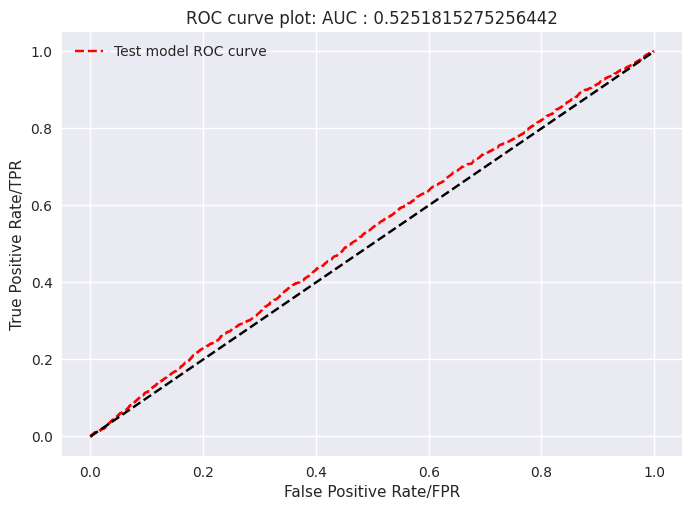

In get patient level transplant status, the final end index is 136538 and length of predicted labels is 136538


<Figure size 800x550 with 0 Axes>

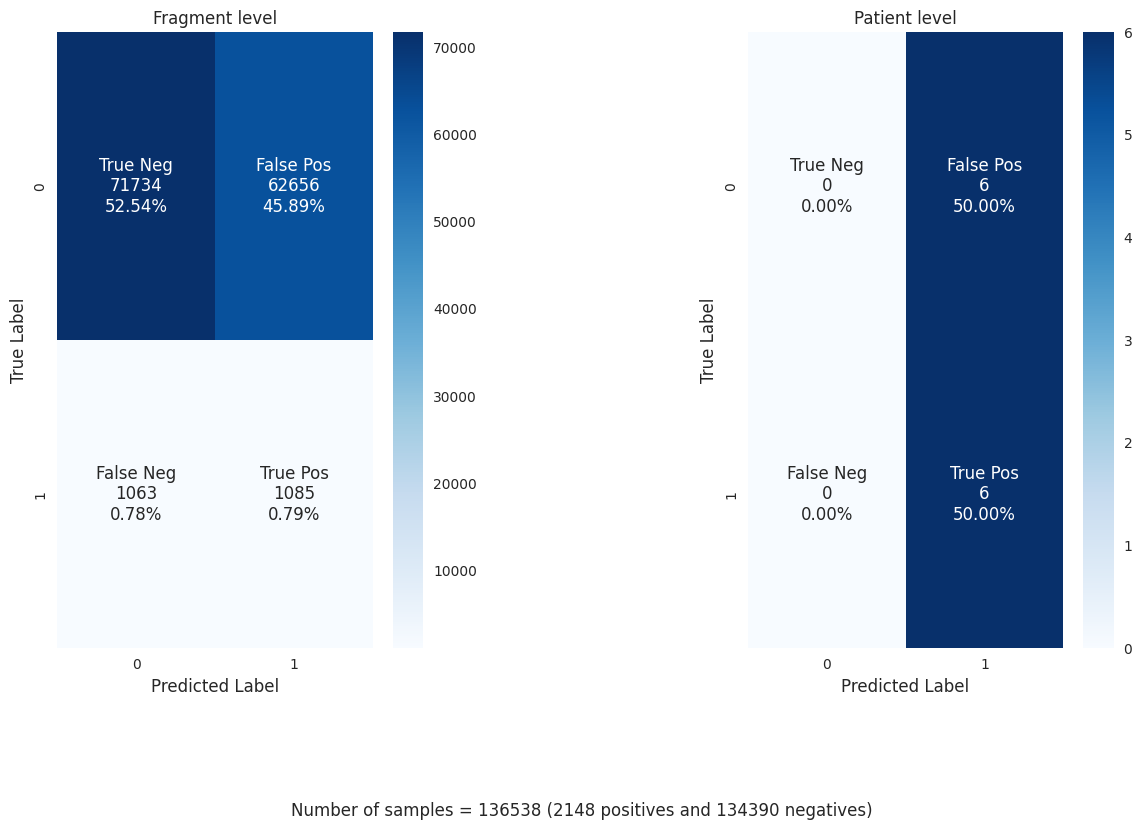

In get patient level transplant status, the final end index is 136538 and length of predicted labels is 136538


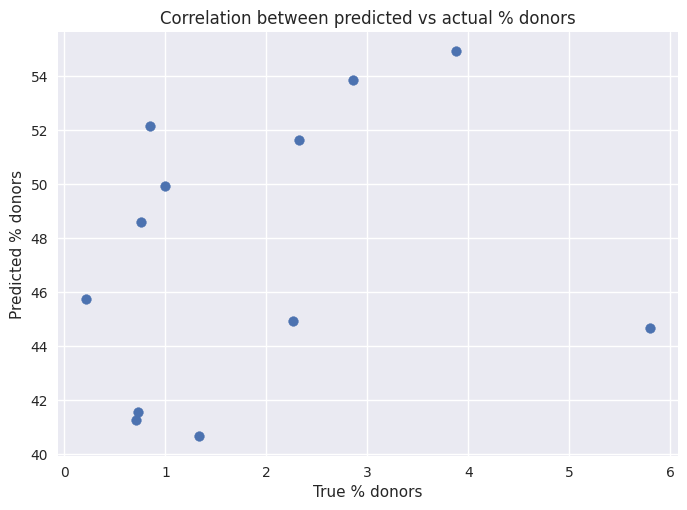

End time is 1694699849.2946656


<Figure size 800x550 with 0 Axes>

In [41]:
if __name__ == '__main__':
    print(f"Start time is {time.time()}")
    runModelAndGetPredictions()   
    print(f"End time is {time.time()}")   

**Get the order in which files are fetched in the sequenceDataset**(If consecutive samples belong to the same file, then the file will be counted in the list only once)

In [ ]:
dataset = sequenceDataset.SequenceDataset("test")
dataloader = DataLoader(dataset, batch_size=arguments["batchSize"], 
                                num_workers=arguments["numWorkers"])

files_list = []
for i, data in enumerate(dataloader):
    filenames = data
    for val in filenames:
        if(len(files_list) == 0):
            files_list.append(val)
        else:
            last_index = len(files_list) - 1
            if(files_list[last_index] != val):
                files_list.append(val)

print(f"The final files list is {files_list}")

In [8]:
print_list = []
filenames = ["a", "a", "b", "a", "c", "b", "a", "d", "d", "d", "c"]
count = 0

for i in range(0, 10):
    print(f"For i : {i}")
    name = filenames[count]
    if(i == 0):
        print_list.append(name)
    else:
        last_index = len(print_list) - 1
        if(print_list[last_index] != name):
            print_list.append(name)
            
    count = count + 1

print(print_list)
    

For i : 0
For i : 1
For i : 2
For i : 3
For i : 4
For i : 5
For i : 6
For i : 7
For i : 8
For i : 9
['a', 'b', 'a', 'c', 'b', 'a', 'd']


In [5]:
dir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latestTestCoordinateFiles"
test_patients = []
count = 0
for filename in os.listdir(dir):
    filepath = os.path.join(dir, filename)
    with h5py.File(filepath, 'r') as f:
        length = len(f["testCoords"][:])
        count = count + length
        print(f"For filename : {filename}, length is {length}")

print(f"Number of samples: {count}")

For filename : L36-M3.recipient.hdf5, length is 316975
For filename : L33-M8.recipient.hdf5, length is 61792
For filename : L80-W2.donor.hdf5, length is 2888
For filename : L79-W2.donor.hdf5, length is 1909
For filename : L68-M12.donor.hdf5, length is 1673
For filename : L77-D1-1.donor.hdf5, length is 18716
For filename : L81-M2.donor.hdf5, length is 3002
For filename : L58-M3.recipient.hdf5, length is 229559
For filename : L59-M12.recipient.hdf5, length is 150928
For filename : L9b-W2.donor.hdf5, length is 1137
For filename : L81-M2.recipient.hdf5, length is 121576
For filename : L82-M1-5.donor.hdf5, length is 3767
For filename : L74-W1.donor.hdf5, length is 3245
For filename : L81-D1.1.donor.hdf5, length is 135735
For filename : L16-M23.recipient.hdf5, length is 105501
For filename : L1-M13.recipient.hdf5, length is 45350
For filename : L77-D1-3.donor.hdf5, length is 36247
For filename : L33-M3.recipient.hdf5, length is 157140
For filename : L85-M9.donor.hdf5, length is 1516
For file

In [14]:
print_list = [1, 2, 3, 4, 5]
last_index = len(print_list) - 1
print_list[last_index]

5